In [ ]:
!export NVIDIA_DIR=$(dirname $(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)")))
!export LD_LIBRARY_PATH=$(echo ${NVIDIA_DIR}/*/lib/ | sed -r 's/\s+/:/g')${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from IPython.display import display
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression,  Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, RegressorMixin

## Data Overview

In [ ]:
root = 'D:/A_STUDY_SPECIAL/Machine_learning/competition/competition_2/data'

df_th = pd.read_csv(os.path.join(root,'th-public.csv'))
df_tbtl = pd.read_csv(os.path.join(root,'tbtl-public.csv'))
df_ck = pd.read_csv(os.path.join(root,'ck-public.csv'))
df_qt = pd.read_csv(os.path.join(root,'qt-public.csv'))
anno_df = pd.read_csv(os.path.join(root,'annonimized.csv'))

df_th.dropna(subset=['TH'], inplace=True)
df_tbtl.dropna(subset=['TBTL'], inplace=True)
df_ck.dropna(subset=['CK'], inplace=True)
df_qt.dropna(subset=['diemqt'], inplace=True)

def overview(df):
    df.info()
    df.describe()
    df.dtypes
    print(df.nunique())
    df.shape

overview(anno_df)
overview(df_th)
overview(df_tbtl)
overview(df_ck)
overview(df_qt)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295198 entries, 0 to 295197
Data columns (total 11 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   concat('it001',`assignment_id`)  295198 non-null  object
 1   concat('it001',`problem_id`)     295198 non-null  object
 2   concat('it001', username)        295198 non-null  object
 3   is_final                         295198 non-null  int64 
 4   status                           295198 non-null  object
 5   pre_score                        295198 non-null  int64 
 6   coefficient                      295198 non-null  int64 
 7   concat('it001',`language_id`)    295198 non-null  object
 8   created_at                       295198 non-null  object
 9   updated_at                       295198 non-null  object
 10  judgement                        295198 non-null  object
dtypes: int64(3), object(8)
memory usage: 24.8+ MB
concat('it001',`assignment_id`) 

In [ ]:
# Chuyển đổi cột điểm sang dạng số, bỏ qua các giá trị không phải số
df_th.iloc[:, 1] = pd.to_numeric(df_th.iloc[:, 1], errors='coerce')
df_tbtl.iloc[:, 1] = pd.to_numeric(df_tbtl.iloc[:, 1], errors='coerce')
df_ck.iloc[:, 1] = pd.to_numeric(df_ck.iloc[:, 1], errors='coerce')
df_qt.iloc[:, 1] = pd.to_numeric(df_qt.iloc[:, 1], errors='coerce')

#Đổi tên các cột trong anno_df, df_tbtl, df_th, df_qt, df_ck để dễ hiểu hơn:
rename_dict = {"concat('it001',`assignment_id`)":"asm_id"
              ,"concat('it001',`problem_id`)":"pro_id"
              ,"concat('it001', username)":"mssv_h"
              ,"concat('it001',`language_id`)":"lang"}
anno_df.rename(columns=rename_dict, inplace=True)
df_tbtl.rename(columns={"username" : "mssv_h"}, inplace=True)
df_th.rename(columns={"hash" : "mssv_h"}, inplace=True)
df_qt.rename(columns={"hash" : "mssv_h"}, inplace=True)
df_ck.rename(columns={"hash" : "mssv_h"}, inplace=True)
display(anno_df.head(5))
display(df_tbtl.head(5))
display(df_qt.head(5))
display(df_th.head(5))
display(df_ck.head(5))

,asm_id,pro_id,mssv_h,is_final,status,pre_score,coefficient,lang,created_at,updated_at,judgement
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."


,mssv_h,TBTL
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.24
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,8.11
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7.30
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,8.63
4,013de369c439ab0ead8aa7da64423aa395a8be39,8.20


,mssv_h,diemqt
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7.0
2,01122b3ef7e59b84189e65985305f575d6bdf83c,9.0
3,013de369c439ab0ead8aa7da64423aa395a8be39,10.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,9.0


,mssv_h,TH
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5.0
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,8.5
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7.0
3,013de369c439ab0ead8aa7da64423aa395a8be39,10.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,6.0


,mssv_h,CK
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,6.5
2,01122b3ef7e59b84189e65985305f575d6bdf83c,4.5
3,013de369c439ab0ead8aa7da64423aa395a8be39,5.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,4.0


## Feature Engineering

n_pro_AC : Số problem đã AC của sinh viên<br>
n_submit_AC: Số submit đã AC của sinh viên

In [ ]:
# Lọc ra những bài nộp AC
ac_submissions = anno_df[(anno_df['is_final'] == 1) & (anno_df['pre_score'] == 10000)]
# Nhóm theo 'mssv_id' và đếm số bài AC cho mỗi sinh viên
pro_ac_count = ac_submissions.groupby('mssv_h')['pro_id'].nunique().reset_index(name='n_pro_AC')
sub_ac_count = ac_submissions.groupby('mssv_h').size().reset_index(name='n_submit_AC')
# Gộp số bài AC này vào df gốc
anno_df = pd.merge(anno_df, pro_ac_count, on='mssv_h', how='left')
anno_df = pd.merge(anno_df, sub_ac_count, on='mssv_h', how='left')
# Điền 0 vào các vị trí NaN (những sinh viên không có bài AC nào)
anno_df['n_pro_AC'] = anno_df['n_pro_AC'].fillna(0).astype(int)
anno_df['n_submit_AC'] = anno_df['n_submit_AC'].fillna(0).astype(int)
display(anno_df)

,asm_id,pro_id,mssv_h,is_final,status,pre_score,coefficient,lang,created_at,updated_at,judgement,n_pro_AC,n_submit_AC
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",96,96
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,"{""times"":[],""mems"":[],""verdicts"":{""\n\nIn func...",96,96
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",96,96
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":[0...",96,96


n_submit : Số submit mà sinh viên đã thực hiện <br>
n_asm_tried : Số assignment sinh viên đã tham gia <br>
n_pro_tried : Số proplem sinh viên đã tham gia

In [ ]:
# Số bài đã nộp
submission_counts = anno_df.groupby('mssv_h').size()
anno_df['n_submit'] = anno_df['mssv_h'].map(submission_counts)
# Số assignment đã thử
asm_tried = anno_df.groupby('mssv_h')['asm_id'].nunique()
anno_df['n_asm_tried'] = anno_df['mssv_h'].map(asm_tried)
# Số problem dã thử
pro_tried = anno_df.groupby('mssv_h')['pro_id'].nunique()
anno_df['n_pro_tried'] = anno_df['mssv_h'].map(pro_tried)
display(anno_df)

,asm_id,pro_id,mssv_h,is_final,status,pre_score,coefficient,lang,created_at,updated_at,judgement,n_pro_AC,n_submit_AC,n_submit,n_asm_tried,n_pro_tried
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56,139,5,58
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56,139,5,58
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56,139,5,58
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56,139,5,58
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56,139,5,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",96,96,228,11,98
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,"{""times"":[],""mems"":[],""verdicts"":{""\n\nIn func...",96,96,228,11,98
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",96,96,228,11,98
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":[0...",96,96,228,11,98


total_score : Tổng điểm các bài nộp đã AC

In [ ]:
passed_df = anno_df[(anno_df['is_final'] == 1) & (anno_df['pre_score'] == 10000)]
passed_df = passed_df.drop_duplicates(subset=['mssv_h', 'pro_id'], keep='first')
# Tính điểm cho mỗi problem_id đã pass
passed_df['score'] = (passed_df['pre_score']/100) * (passed_df['coefficient']/100)
# Tính tổng điểm cho mỗi mssv
total_scores = passed_df.groupby('mssv_h')['score'].sum().reset_index(name='total_score')
# Gán tổng điểm vào df gốc
anno_df = anno_df.merge(total_scores, on='mssv_h', how='left')
# Điền các giá trị NaN bằng 0 nếu sinh viên không có bài nào pass
anno_df['total_score'] = anno_df['total_score'].fillna(0)
display(anno_df)

,asm_id,pro_id,mssv_h,is_final,status,pre_score,coefficient,lang,created_at,updated_at,judgement,n_pro_AC,n_submit_AC,n_submit,n_asm_tried,n_pro_tried,total_score
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56,139,5,58,5600.0
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56,139,5,58,5600.0
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56,139,5,58,5600.0
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56,139,5,58,5600.0
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",56,56,139,5,58,5600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",96,96,228,11,98,9600.0
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,"{""times"":[],""mems"":[],""verdicts"":{""\n\nIn func...",96,96,228,11,98,9600.0
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",96,96,228,11,98,9600.0
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":[0...",96,96,228,11,98,9600.0


month_1, month_2, ..., month_12 : Số bài nộp của sinh viên trong tháng tương ứng <br>
0-2, 3-5, ..., 21-23 : Số bài nộp của sinh viên trong khung giờ tương ứng

In [ ]:
# Thêm năm 2024 vào vì trong cột created_at có ngày 29-2
anno_df['date'] = pd.to_datetime('2024-' + anno_df['created_at'], format='%Y-%m-%d %H:%M:%S')

# THêm các cột số baì nộp theo tháng của sinh viên
anno_df['month'] = anno_df['date'].dt.month
month_dummies = pd.get_dummies(anno_df['month'], prefix='month')
anno_df = pd.concat([anno_df, month_dummies], axis=1)

anno_df['hour'] = anno_df['date'].dt.hour
for column in month_dummies.columns:
    anno_df[column] = anno_df.groupby('mssv_h')[column].transform('sum')

bins = [0, 3, 6, 9, 12, 15, 18, 21, 24]
labels = ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '18-20', '21-23']
# Phân loại dữ liệu theo các khoảng giờ
anno_df['time_slot'] = pd.cut(anno_df['hour'], bins=bins, labels=labels, right=True)
# Tạo các cột mới cho mỗi khoảng giờ và tính số lượng bài nộp
for label in labels:
    anno_df[label] = (anno_df['time_slot'] == label).astype(int)
    anno_df[label] = anno_df.groupby('mssv_h')[label].transform('sum')

anno_df = anno_df.drop(columns=['hour','time_slot', 'date'])
display(anno_df)

,asm_id,pro_id,mssv_h,is_final,status,pre_score,coefficient,lang,created_at,updated_at,...,month_11,month_12,0-2,3-5,6-8,9-11,12-14,15-17,18-20,21-23
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,...,31,0,8,20,47,26,17,15,0,0
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,...,31,0,8,20,47,26,17,15,0,0
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,...,31,0,8,20,47,26,17,15,0,0
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,...,31,0,8,20,47,26,17,15,0,0
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,...,31,0,8,20,47,26,17,15,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,...,69,39,17,14,49,28,73,34,12,1
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,...,69,39,17,14,49,28,73,34,12,1
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,...,69,39,17,14,49,28,73,34,12,1
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,...,69,39,17,14,49,28,73,34,12,1


status__Compilation Error : Số bài nộp của sinh viên có trạng thái Compilation Error <br>
status__SCORE : Số bài nộp của sinh viên được chấm <br>
status__Syntax Error : Số bài nộp của sinh viên có trạng thái Syntax Error <br>
status__pending : Số bài nộp của sinh viên có trạng thái pending <br>

In [ ]:
status_dummies = pd.get_dummies(anno_df['status'], prefix='status_')
df_expanded = pd.concat([anno_df, status_dummies], axis=1)
df_grouped = df_expanded.groupby('mssv_h')[status_dummies.columns].sum().reset_index()
anno_df = anno_df.merge(df_grouped, on='mssv_h', how='left')
display(anno_df)
del df_expanded, df_grouped

,asm_id,pro_id,mssv_h,is_final,status,pre_score,coefficient,lang,created_at,updated_at,...,6-8,9-11,12-14,15-17,18-20,21-23,status__Compilation Error,status__SCORE,status__Syntax Error,status__pending
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,...,47,26,17,15,0,0,34,105,0,0
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,...,47,26,17,15,0,0,34,105,0,0
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,...,47,26,17,15,0,0,34,105,0,0
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,...,47,26,17,15,0,0,34,105,0,0
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,...,47,26,17,15,0,0,34,105,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,...,49,28,73,34,12,1,45,183,0,0
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,...,49,28,73,34,12,1,45,183,0,0
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,...,49,28,73,34,12,1,45,183,0,0
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,...,49,28,73,34,12,1,45,183,0,0


ratio_proAC/submit : Tỷ lệ phần trăm của số vấn đề được giải (n_pro_AC) so với tổng số lần nộp (n_submit).

ratio_subAC/submit : Tỷ lệ phần trăm của số lần nộp giải được (n_submit_AC) so với tổng số lần nộp

ratio_error/submit : Tỷ lệ phần trăm lỗi, được tính bằng cách lấy (1 trừ đi tỷ lệ status__SCORE so với tổng số lần nộp (n_submit))

ratio_0-5/submit : Tỷ lệ phần trăm sinh viên nộp bài trong khoảng từ 0h đến 5h trong tổng số bài submit

In [ ]:
anno_df['ratio_proAC/submit'] = anno_df['n_pro_AC'] / anno_df['n_submit'] * 100

anno_df['ratio_subAC/submit'] = anno_df['n_submit_AC'] / anno_df['n_submit'] * 100

anno_df['ratio_error/submit'] = (1 - anno_df['status__SCORE']/anno_df['n_submit']) * 100

anno_df['ratio_0-5/submit'] = (anno_df['0-2']+anno_df['3-5'])/anno_df['n_submit'] * 100
display(anno_df)

,asm_id,pro_id,mssv_h,is_final,status,pre_score,coefficient,lang,created_at,updated_at,...,18-20,21-23,status__Compilation Error,status__SCORE,status__Syntax Error,status__pending,ratio_proAC/submit,ratio_subAC/submit,ratio_error/submit,ratio_0-5/submit
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,...,0,0,34,105,0,0,40.287770,40.287770,24.460432,20.143885
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,...,0,0,34,105,0,0,40.287770,40.287770,24.460432,20.143885
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,...,0,0,34,105,0,0,40.287770,40.287770,24.460432,20.143885
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,...,0,0,34,105,0,0,40.287770,40.287770,24.460432,20.143885
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,...,0,0,34,105,0,0,40.287770,40.287770,24.460432,20.143885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,...,12,1,45,183,0,0,42.105263,42.105263,19.736842,13.596491
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,...,12,1,45,183,0,0,42.105263,42.105263,19.736842,13.596491
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,...,12,1,45,183,0,0,42.105263,42.105263,19.736842,13.596491
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,...,12,1,45,183,0,0,42.105263,42.105263,19.736842,13.596491


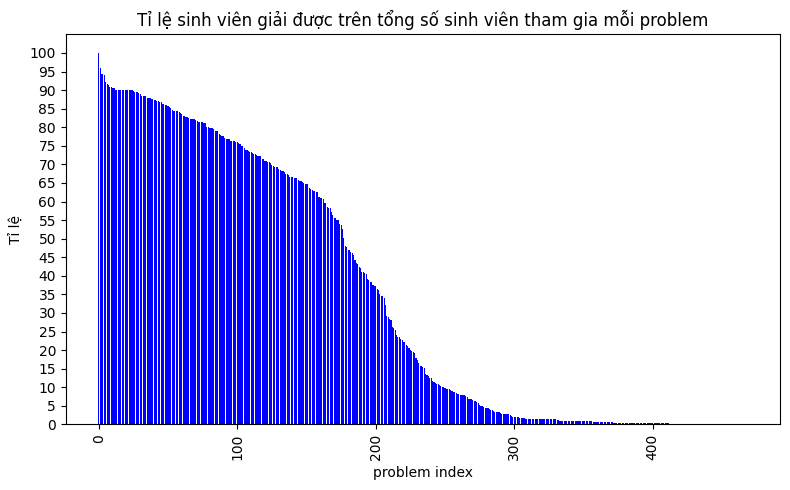

In [ ]:
#Xác định các asm_id cho mỗi pro_id
assignments_per_problem = anno_df.groupby('pro_id')['asm_id'].unique()
#Tính số lượng sinh viên đã tham gia mỗi asm_id
students_per_assignment = anno_df.groupby('asm_id')['mssv_h'].nunique()
#Xác định số sinh viên đã tham gia mỗi pro_id thông qua các asm_id
students_per_problem = assignments_per_problem.apply(lambda x: students_per_assignment.loc[x].sum())
#Tính số sinh viên đã giải được mỗi pro_id
final_solutions = anno_df[(anno_df['is_final'] == 1) & (anno_df['pre_score'] == 10000)]
solved_counts = final_solutions.groupby('pro_id')['mssv_h'].nunique()
#Tính tỷ lệ giữa số sinh viên đã giải được và số sinh viên đã tham gia
solved_ratio = (solved_counts / students_per_problem * 100).fillna(0)
#Tạo DataFrame mới với thông ti
lv_df = pd.DataFrame({
    'pro_id': students_per_problem.index,
    'participated': students_per_problem.values,
    'solved': solved_counts.reindex(students_per_problem.index, fill_value=0).values,
    'ratio_solved/participated': solved_ratio.values
})

lv_df_sorted = lv_df.sort_values(by='ratio_solved/participated', ascending=False)
plt.figure(figsize=(8, 5))
plt.bar(range(len(lv_df_sorted)), lv_df_sorted['ratio_solved/participated'], color='blue')
plt.xlabel('problem index')
plt.ylabel('Tỉ lệ')
plt.title('Tỉ lệ sinh viên giải được trên tổng số sinh viên tham gia mỗi problem')
plt.xticks(rotation=90)
plt.yticks(range(0, 101, 5))
plt.tight_layout()
plt.show()

In [ ]:
def classify_ratio(ratio):
    if ratio >= 60:
        return 'level_1'
    elif 35 <= ratio < 60:
        return 'level_2'
    elif 20 <= ratio < 35:
        return 'level_3'
    elif 10 <= ratio < 20:
        return 'level_4'
    else:
        return 'level_5'

# Tạo cột mới 'level' dựa trên các giá trị của cột 'ratio_solved/participated'
lv_df['level'] = lv_df['ratio_solved/participated'].apply(classify_ratio)
lv_df.to_csv('lv.csv', index=False)
display(lv_df)

,pro_id,participated,solved,ratio_solved/participated,level
0,008f8e9b0f4fac6b5f188f0dc8d118a8b19aabee,1319,890,67.475360,level_1
1,013e2f57867e3ab62d2043beecedade7ea6cf545,292,8,2.739726,level_5
2,017ff00dd3fe1e6f8297b5061215343742259f6a,697,451,64.705882,level_1
3,027fd74619cb74676a464759ddfeb06457d80aa4,292,4,1.369863,level_5
4,028df0dceb107528f66ee892dae5ded64b21d470,46,13,28.260870,level_3
...,...,...,...,...,...
464,fd761cbe57c9f2eea1cdebc5cc708fafa95dda40,292,0,0.000000,level_5
465,fe90c40607a0d2caacfc1b1083de4e3f6a6c9c10,1292,647,50.077399,level_2
466,ff75347a4671d84aba7db89af5a1de668661f692,1358,906,66.715758,level_1
467,ffbf74d579d9fef54254fb6ee0a579d26b052ecc,292,0,0.000000,level_5


In [ ]:
# Ghép cột level vào df gốc
anno_df = pd.merge(anno_df, lv_df[['pro_id', 'level']], on='pro_id', how='left')
# Lọc các bài nộp được chấp nhận (AC)
ac_submissions = anno_df[(anno_df['is_final'] == 1) & (anno_df['pre_score'] == 10000)]
# Nhóm theo mssv_h và level, đếm số lượng
level_counts = ac_submissions.groupby(['mssv_h', 'level']).size().unstack(fill_value=0).reset_index()
# Gộp vào df gốc
anno_df = pd.merge(anno_df, level_counts, on='mssv_h', how='left')
# Điền 0 vào các vị trí NaN
level_columns = ['level_1', 'level_2', 'level_3', 'level_4', 'level_5']
for column in level_columns:
    anno_df[column] = anno_df[column].fillna(0).astype(int)
# Hiển thị kết quả
anno_df.drop(columns='level', inplace=True)
display(anno_df)

,asm_id,pro_id,mssv_h,is_final,status,pre_score,coefficient,lang,created_at,updated_at,...,status__pending,ratio_proAC/submit,ratio_subAC/submit,ratio_error/submit,ratio_0-5/submit,level_1,level_2,level_3,level_4,level_5
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,...,0,40.287770,40.287770,24.460432,20.143885,54,2,0,0,0
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,...,0,40.287770,40.287770,24.460432,20.143885,54,2,0,0,0
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,...,0,40.287770,40.287770,24.460432,20.143885,54,2,0,0,0
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,...,0,40.287770,40.287770,24.460432,20.143885,54,2,0,0,0
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,...,0,40.287770,40.287770,24.460432,20.143885,54,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,...,0,42.105263,42.105263,19.736842,13.596491,87,9,0,0,0
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,...,0,42.105263,42.105263,19.736842,13.596491,87,9,0,0,0
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,...,0,42.105263,42.105263,19.736842,13.596491,87,9,0,0,0
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,...,0,42.105263,42.105263,19.736842,13.596491,87,9,0,0,0


Onehot-encoding các cột pro_id, lang, asm_id

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
anno_df['pro_id'] = anno_df['pro_id'].str.strip()
# Thực hiện fit_transform trên cột 'assignment_id'
encoded_columns = encoder.fit_transform(anno_df[['pro_id']])
# Lấy tên các cột sau khi encoding và thêm tiền tố 'in__'
encoded_column_names = ['in__' + cat for cat in encoder.categories_[0]]
# Tạo DataFrame cho các cột đã được One-Hot Encoded
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_column_names)
# Kết hợp DataFrame ban đầu với các cột mới
anno_df = pd.concat([anno_df, encoded_df], axis=1)

encoder2 = OneHotEncoder(sparse_output=False)
anno_df['lang'] = anno_df['lang'].str.strip()
# Thực hiện fit_transform trên cột 'assignment_id'
encoded2_columns = encoder2.fit_transform(anno_df[['lang']])
# Lấy tên các cột sau khi encoding và thêm tiền tố 'in__'
encoded2_column_names = ['in__' + cat for cat in encoder2.categories_[0]]
# Tạo DataFrame cho các cột đã được One-Hot Encoded
encoded2_df = pd.DataFrame(encoded2_columns, columns=encoded2_column_names)
# Kết hợp DataFrame ban đầu với các cột mới
anno_df = pd.concat([anno_df, encoded2_df], axis=1)

encoder3 = OneHotEncoder(sparse_output=False)
anno_df['asm_id'] = anno_df['asm_id'].str.strip()
# Thực hiện fit_transform trên cột 'assignment_id'
encoded3_columns = encoder3.fit_transform(anno_df[['asm_id']])
# Lấy tên các cột sau khi encoding và thêm tiền tố 'in__'
encoded3_column_names = ['in__' + cat for cat in encoder3.categories_[0]]
# Tạo DataFrame cho các cột đã được One-Hot Encoded
encoded3_df = pd.DataFrame(encoded3_columns, columns=encoded3_column_names)
# Kết hợp DataFrame ban đầu với các cột mới
anno_df = pd.concat([anno_df, encoded3_df], axis=1)
display(anno_df)

,asm_id,pro_id,mssv_h,is_final,status,pre_score,coefficient,lang,created_at,updated_at,...,in__f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,in__f89d30fccecbe52278b59e9294d868e3c51fbff4,in__f8d46b863c7cb8ec934fa0043264dfdb01209630,in__fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,in__fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,in__fdb39b60bce4591bdac572cc1f03d4f3417df16e,in__fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,in__feac75b57862fb1653d3835bea439742ea93c8c8,in__febe93930de7a9a910e8a55177a7bce45de7329b,in__ff1bb207f10b6d6999751f65f3abf047f2b9242c
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def create_train_predict_df(df, anno_df):
    train_df = df.copy()
    sv_id = train_df['mssv_h']
    sv_id_anno = anno_df['mssv_h']
    # Tìm các giá trị "sv_id" có trong annonimized_df nhưng không có trong df_th - cần predict
    unique_sv_ids = sv_id_anno[~sv_id_anno.isin(sv_id)]
    # Lọc các hàng trong annonimized_df mà có "sv_id" nằm trong unique_sv_ids
    fil_df = anno_df[anno_df['mssv_h'].isin(unique_sv_ids)]
    unique_values = fil_df['mssv_h'].unique()
    predict_df = pd.DataFrame(unique_values, columns=['mssv_h'])
    predict_col = df.columns[1]
    train_df.rename(columns=rename_dict, inplace=True)
    ac_summary = anno_df.groupby('mssv_h').first().reset_index()
    train_df = pd.merge(train_df, ac_summary, on='mssv_h', how='left')
    predict_df = pd.merge(predict_df, ac_summary, on='mssv_h', how='left')
    original_col = ['asm_id', 'pro_id', 'is_final', 'status', 'pre_score', 'coefficient', 'lang', 'created_at', 'updated_at', 'judgement']
    train_df.drop(columns=original_col, inplace=True)
    predict_df.drop(columns=original_col, inplace=True)
    train_df.dropna(subset=predict_col, inplace=True)
    return train_df, predict_df

train_df_TH, predict_df_TH = create_train_predict_df(df_th, anno_df)
train_df_QT, predict_df_QT = create_train_predict_df(df_qt, anno_df)
train_df_CK, predict_df_CK = create_train_predict_df(df_ck, anno_df)
train_df_TL, predict_df_TL = create_train_predict_df(df_tbtl, anno_df)

### Dataset

train_df: chứa mssv, feature và label train model

predict_df: chứa feature và msss cần được predict để submit

#### TH

In [ ]:
train_df_TH

,mssv_h,TH,n_pro_AC,n_submit_AC,n_submit,n_asm_tried,n_pro_tried,total_score,month,month_1,...,in__f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,in__f89d30fccecbe52278b59e9294d868e3c51fbff4,in__f8d46b863c7cb8ec934fa0043264dfdb01209630,in__fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,in__fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,in__fdb39b60bce4591bdac572cc1f03d4f3417df16e,in__fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,in__feac75b57862fb1653d3835bea439742ea93c8c8,in__febe93930de7a9a910e8a55177a7bce45de7329b,in__ff1bb207f10b6d6999751f65f3abf047f2b9242c
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5.0,45,46,147,7,46,4500.0,9,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,8.5,72,72,259,9,78,7200.0,9,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7.0,58,59,195,7,66,5800.0,9,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,013de369c439ab0ead8aa7da64423aa395a8be39,10.0,44,58,107,8,52,4400.0,10,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,6.0,79,79,199,9,90,7900.0,10,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,840d07858c03f80f4695056e2cc7d0c474b83a25,6.0,37,39,111,6,43,3700.0,9,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
751,844f5db2e7e31ae51eba025480679ed7e4708ac6,8.5,102,102,357,17,104,10200.0,9,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752,845acd04a77b3d1b623f255d9f9f8eae90892dab,5.5,47,47,155,8,52,4700.0,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753,8460eaaf887a6289fb156f7562fb739ba8e9629e,10.0,109,109,557,12,114,10900.0,9,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
predict_df_TH

,mssv_h,n_pro_AC,n_submit_AC,n_submit,n_asm_tried,n_pro_tried,total_score,month,month_1,month_2,...,in__f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,in__f89d30fccecbe52278b59e9294d868e3c51fbff4,in__f8d46b863c7cb8ec934fa0043264dfdb01209630,in__fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,in__fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,in__fdb39b60bce4591bdac572cc1f03d4f3417df16e,in__fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,in__feac75b57862fb1653d3835bea439742ea93c8c8,in__febe93930de7a9a910e8a55177a7bce45de7329b,in__ff1bb207f10b6d6999751f65f3abf047f2b9242c
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,56,56,139,5,58,5600.0,10,48,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ba12c0a2cb367af0467e479c03507c71a805d291,112,117,319,6,112,11200.0,9,95,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b7298b0fe50443a623af9b56792b330c2d052845,108,108,247,5,110,10800.0,9,98,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c60be70309789b39355dc612f36e37090ccad5dc,76,76,172,10,83,7600.0,9,40,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b,98,98,288,11,103,9800.0,9,28,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,508e0627871ed482bd8ab34544e43e5d856a889c,33,33,94,4,33,3300.0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
730,d525d6edf4b0c6362ddaa4814c3930a6a62bdc99,97,97,217,10,98,9700.0,9,22,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
731,b722e6209f2858faf0bf80947cadcbde586bb666,22,22,136,3,26,2200.0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
732,b45e8d507778dab56f381a681c453cbf4d3b4050,45,45,141,10,53,4500.0,9,35,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### QT

In [ ]:
train_df_QT

,mssv_h,diemqt,n_pro_AC,n_submit_AC,n_submit,n_asm_tried,n_pro_tried,total_score,month,month_1,...,in__f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,in__f89d30fccecbe52278b59e9294d868e3c51fbff4,in__f8d46b863c7cb8ec934fa0043264dfdb01209630,in__fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,in__fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,in__fdb39b60bce4591bdac572cc1f03d4f3417df16e,in__fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,in__feac75b57862fb1653d3835bea439742ea93c8c8,in__febe93930de7a9a910e8a55177a7bce45de7329b,in__ff1bb207f10b6d6999751f65f3abf047f2b9242c
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.5,45,46,147,7,46,4500.0,9,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7.0,72,72,259,9,78,7200.0,9,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01122b3ef7e59b84189e65985305f575d6bdf83c,9.0,58,59,195,7,66,5800.0,9,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,013de369c439ab0ead8aa7da64423aa395a8be39,10.0,44,58,107,8,52,4400.0,10,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,9.0,79,79,199,9,90,7900.0,10,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,840d07858c03f80f4695056e2cc7d0c474b83a25,9.0,37,39,111,6,43,3700.0,9,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
751,844f5db2e7e31ae51eba025480679ed7e4708ac6,8.0,102,102,357,17,104,10200.0,9,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752,845acd04a77b3d1b623f255d9f9f8eae90892dab,6.5,47,47,155,8,52,4700.0,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753,8460eaaf887a6289fb156f7562fb739ba8e9629e,10.0,109,109,557,12,114,10900.0,9,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
predict_df_QT

,mssv_h,n_pro_AC,n_submit_AC,n_submit,n_asm_tried,n_pro_tried,total_score,month,month_1,month_2,...,in__f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,in__f89d30fccecbe52278b59e9294d868e3c51fbff4,in__f8d46b863c7cb8ec934fa0043264dfdb01209630,in__fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,in__fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,in__fdb39b60bce4591bdac572cc1f03d4f3417df16e,in__fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,in__feac75b57862fb1653d3835bea439742ea93c8c8,in__febe93930de7a9a910e8a55177a7bce45de7329b,in__ff1bb207f10b6d6999751f65f3abf047f2b9242c
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,56,56,139,5,58,5600.0,10,48,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ba12c0a2cb367af0467e479c03507c71a805d291,112,117,319,6,112,11200.0,9,95,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b7298b0fe50443a623af9b56792b330c2d052845,108,108,247,5,110,10800.0,9,98,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c60be70309789b39355dc612f36e37090ccad5dc,76,76,172,10,83,7600.0,9,40,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b,98,98,288,11,103,9800.0,9,28,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,508e0627871ed482bd8ab34544e43e5d856a889c,33,33,94,4,33,3300.0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
730,d525d6edf4b0c6362ddaa4814c3930a6a62bdc99,97,97,217,10,98,9700.0,9,22,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
731,b722e6209f2858faf0bf80947cadcbde586bb666,22,22,136,3,26,2200.0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
732,b45e8d507778dab56f381a681c453cbf4d3b4050,45,45,141,10,53,4500.0,9,35,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### CK

In [ ]:
train_df_CK

,mssv_h,CK,n_pro_AC,n_submit_AC,n_submit,n_asm_tried,n_pro_tried,total_score,month,month_1,...,in__f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,in__f89d30fccecbe52278b59e9294d868e3c51fbff4,in__f8d46b863c7cb8ec934fa0043264dfdb01209630,in__fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,in__fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,in__fdb39b60bce4591bdac572cc1f03d4f3417df16e,in__fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,in__feac75b57862fb1653d3835bea439742ea93c8c8,in__febe93930de7a9a910e8a55177a7bce45de7329b,in__ff1bb207f10b6d6999751f65f3abf047f2b9242c
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5.5,45,46,147,7,46,4500.0,9,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,6.5,72,72,259,9,78,7200.0,9,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01122b3ef7e59b84189e65985305f575d6bdf83c,4.5,58,59,195,7,66,5800.0,9,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,013de369c439ab0ead8aa7da64423aa395a8be39,5.0,44,58,107,8,52,4400.0,10,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,4.0,79,79,199,9,90,7900.0,10,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,840d07858c03f80f4695056e2cc7d0c474b83a25,5.5,37,39,111,6,43,3700.0,9,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
751,844f5db2e7e31ae51eba025480679ed7e4708ac6,6.0,102,102,357,17,104,10200.0,9,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752,845acd04a77b3d1b623f255d9f9f8eae90892dab,6.0,47,47,155,8,52,4700.0,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753,8460eaaf887a6289fb156f7562fb739ba8e9629e,7.0,109,109,557,12,114,10900.0,9,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
predict_df_CK

,mssv_h,n_pro_AC,n_submit_AC,n_submit,n_asm_tried,n_pro_tried,total_score,month,month_1,month_2,...,in__f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,in__f89d30fccecbe52278b59e9294d868e3c51fbff4,in__f8d46b863c7cb8ec934fa0043264dfdb01209630,in__fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,in__fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,in__fdb39b60bce4591bdac572cc1f03d4f3417df16e,in__fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,in__feac75b57862fb1653d3835bea439742ea93c8c8,in__febe93930de7a9a910e8a55177a7bce45de7329b,in__ff1bb207f10b6d6999751f65f3abf047f2b9242c
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,56,56,139,5,58,5600.0,10,48,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ba12c0a2cb367af0467e479c03507c71a805d291,112,117,319,6,112,11200.0,9,95,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b7298b0fe50443a623af9b56792b330c2d052845,108,108,247,5,110,10800.0,9,98,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c60be70309789b39355dc612f36e37090ccad5dc,76,76,172,10,83,7600.0,9,40,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b,98,98,288,11,103,9800.0,9,28,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,508e0627871ed482bd8ab34544e43e5d856a889c,33,33,94,4,33,3300.0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
730,d525d6edf4b0c6362ddaa4814c3930a6a62bdc99,97,97,217,10,98,9700.0,9,22,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
731,b722e6209f2858faf0bf80947cadcbde586bb666,22,22,136,3,26,2200.0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
732,b45e8d507778dab56f381a681c453cbf4d3b4050,45,45,141,10,53,4500.0,9,35,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### TL

In [ ]:
train_df_TL

,mssv_h,TBTL,n_pro_AC,n_submit_AC,n_submit,n_asm_tried,n_pro_tried,total_score,month,month_1,...,in__f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,in__f89d30fccecbe52278b59e9294d868e3c51fbff4,in__f8d46b863c7cb8ec934fa0043264dfdb01209630,in__fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,in__fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,in__fdb39b60bce4591bdac572cc1f03d4f3417df16e,in__fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,in__feac75b57862fb1653d3835bea439742ea93c8c8,in__febe93930de7a9a910e8a55177a7bce45de7329b,in__ff1bb207f10b6d6999751f65f3abf047f2b9242c
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.24,45,46,147,7,46,4500.0,9,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,8.11,72,72,259,9,78,7200.0,9,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7.30,58,59,195,7,66,5800.0,9,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,8.63,47,47,100,4,47,4700.0,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,013de369c439ab0ead8aa7da64423aa395a8be39,8.20,44,58,107,8,52,4400.0,10,19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,840d07858c03f80f4695056e2cc7d0c474b83a25,7.67,37,39,111,6,43,3700.0,9,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
795,844f5db2e7e31ae51eba025480679ed7e4708ac6,7.54,102,102,357,17,104,10200.0,9,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,845acd04a77b3d1b623f255d9f9f8eae90892dab,7.49,47,47,155,8,52,4700.0,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,8460eaaf887a6289fb156f7562fb739ba8e9629e,8.94,109,109,557,12,114,10900.0,9,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
predict_df_TL

,mssv_h,n_pro_AC,n_submit_AC,n_submit,n_asm_tried,n_pro_tried,total_score,month,month_1,month_2,...,in__f86c876f6d60b3b0c14fb0f084c705f1c4bb3dad,in__f89d30fccecbe52278b59e9294d868e3c51fbff4,in__f8d46b863c7cb8ec934fa0043264dfdb01209630,in__fa76cedef89934b5a8c9b6f93744b2cbdd941e6d,in__fd8fdf743e38d0dc3e613563f3ce1ad0301235bb,in__fdb39b60bce4591bdac572cc1f03d4f3417df16e,in__fe1bf6b299645a8e2502b0a43fa57d650d1b1b41,in__feac75b57862fb1653d3835bea439742ea93c8c8,in__febe93930de7a9a910e8a55177a7bce45de7329b,in__ff1bb207f10b6d6999751f65f3abf047f2b9242c
0,ed9eaeb6a707f50154024b24d7efcb874a9795dd,56,56,139,5,58,5600.0,10,48,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ba12c0a2cb367af0467e479c03507c71a805d291,112,117,319,6,112,11200.0,9,95,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b7298b0fe50443a623af9b56792b330c2d052845,108,108,247,5,110,10800.0,9,98,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,c60be70309789b39355dc612f36e37090ccad5dc,76,76,172,10,83,7600.0,9,40,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b,98,98,288,11,103,9800.0,9,28,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,f0d74f349e6479eaecf425634f8b0dd51e60d60c,54,54,229,6,61,5400.0,10,70,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
686,d525d6edf4b0c6362ddaa4814c3930a6a62bdc99,97,97,217,10,98,9700.0,9,22,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
687,b722e6209f2858faf0bf80947cadcbde586bb666,22,22,136,3,26,2200.0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
688,b45e8d507778dab56f381a681c453cbf4d3b4050,45,45,141,10,53,4500.0,9,35,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train

In [ ]:
class WeightedVotingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        weighted_predictions = np.average(predictions, axis=0, weights=self.weights)
        return weighted_predictions

def search_model(X, y, random_seed, models):
    best_models = []
    i = 0
    for name, model, params in models:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])

        param_grid = {
            'scaler': [StandardScaler(), MinMaxScaler(), None]
        }
        param_grid.update(params)
        kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
        grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='r2', n_jobs=12, verbose = 1)
        grid_search.fit(X, y)

        cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=kf, scoring='r2')
        mean_cv_score = np.mean(cv_scores)

        i += 1
        print(f"#{i} Model: {name}")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Mean cross-validation score: {mean_cv_score}")
        best = grid_search.best_estimator_
        best_models.append(best)
        print('-' * 30)

    return best_models

In [ ]:
models = [
        #1
        ('linear', LinearRegression(), {
        }),
        #2
        ('ridge', Ridge(), {
            'regressor__alpha': [0.5, 1, 1.5, 2, 2.5, 3, 4, 5]
        }),
        #3
        ('lasso', Lasso(max_iter=500000), {
            'regressor__alpha':  [0.2, 0.4, 0.6, 0.8, 1]
        }),
        #4
        ('elastic_net', ElasticNet(max_iter=500000), {
            'regressor__alpha': [0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3],
            'regressor__l1_ratio': [0.2, 0.4, 0.6, 0.8, 1]
        }),
        #5
        ('svr', SVR(), {
            'regressor__C': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0 ,7.0],
            'regressor__kernel': ['rbf'],
            'regressor__epsilon': [0.2, 0.4, 0.6, 0.8, 1]
        }),
        # #6
        # ('random_forest', RandomForestRegressor(random_state=123456), {
        #     'regressor__n_estimators': [50, 70, 100],
        #     'regressor__max_depth': [None, 3, 5, 7, 10]
        # }),
        # #7
        # ('knn_regressor', KNeighborsRegressor(), {
        #     'regressor__n_neighbors': [3, 5, 10],
        #     'regressor__weights': ['uniform', 'distance']
        # }),
        #8
        ('adaboost', AdaBoostRegressor(random_state=123456), {
            'regressor__n_estimators': [10, 30, 50, 100, 200, 300],
            'regressor__learning_rate': [0.01, 0.03, 0.1]
        }),
        # #9
        # ('xgboost', xgb.XGBRegressor(), {
        #     'regressor__n_estimators': [100, 200, 300],
        #     'regressor__max_depth': [3, 5, 7],
        #     'regressor__learning_rate': [0.01, 0.1, 0.2]
        # })
    ]

Tìm mô hình và tham số  cho dự đoán điểm quá trình

In [ ]:
search_model(train_df_QT.drop(columns=[train_df_QT.columns[1], 'mssv_h']), train_df_QT[train_df_QT.columns[1]], 123456, models)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
#1 Model: linear
Best parameters: {'scaler': None}
Mean cross-validation score: 0.1879415258601907
------------------------------
Fitting 5 folds for each of 24 candidates, totalling 120 fits
#2 Model: ridge
Best parameters: {'regressor__alpha': 3, 'scaler': MinMaxScaler()}
Mean cross-validation score: 0.3392460077975473
------------------------------
Fitting 5 folds for each of 15 candidates, totalling 75 fits
#3 Model: lasso
Best parameters: {'regressor__alpha': 0.2, 'scaler': StandardScaler()}
Mean cross-validation score: 0.21672581232102878
------------------------------
Fitting 5 folds for each of 120 candidates, totalling 600 fits
#4 Model: elastic_net
Best parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.4, 'scaler': StandardScaler()}
Mean cross-validation score: 0.3416819247001839
------------------------------
Fitting 5 folds for each of 105 candidates, totalling 525 fits
#5 Model: svr
Best parameters: {

[Pipeline(steps=[('scaler', None), ('regressor', LinearRegression())]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', Ridge(alpha=3))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', Lasso(alpha=0.2, max_iter=500000))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor',
                  ElasticNet(alpha=0.1, l1_ratio=0.4, max_iter=500000))]),
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('regressor', SVR(C=5.0, epsilon=0.4))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor',
                  AdaBoostRegressor(learning_rate=0.03, random_state=123456))])]

In [ ]:
X_QT = train_df_QT.drop(columns=[train_df_QT.columns[1], 'mssv_h'])
y_QT = train_df_QT[train_df_QT.columns[1]]

model_QT1 = Pipeline(steps=[('scaler', MinMaxScaler()),
                            ('regressor', SVR(C=5.0, epsilon=0.4))])
model_QT1.fit(X_QT, y_QT)

model_QT2 = Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.4, max_iter=100000))])
model_QT2.fit(X_QT, y_QT)

list_model_QT = [model_QT1, model_QT2]
list_w_QT = [0.5, 0.5]
voting_QT = WeightedVotingRegressor(models=list_model_QT, weights=list_w_QT)

Tìm mô hình và tham số cho dự đoán điểm thực hành

In [ ]:
search_model(train_df_TH.drop(columns=[train_df_TH.columns[1], 'mssv_h']), train_df_TH[train_df_TH.columns[1]], 123456, models)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
#1 Model: linear
Best parameters: {'scaler': None}
Mean cross-validation score: -3732262135.057616
------------------------------
Fitting 5 folds for each of 24 candidates, totalling 120 fits
#2 Model: ridge
Best parameters: {'regressor__alpha': 2.5, 'scaler': MinMaxScaler()}
Mean cross-validation score: 0.4417714026051457
------------------------------
Fitting 5 folds for each of 15 candidates, totalling 75 fits
#3 Model: lasso
Best parameters: {'regressor__alpha': 0.2, 'scaler': StandardScaler()}
Mean cross-validation score: 0.3175444657069201
------------------------------
Fitting 5 folds for each of 120 candidates, totalling 600 fits
#4 Model: elastic_net
Best parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.4, 'scaler': StandardScaler()}
Mean cross-validation score: 0.43261285335067
------------------------------
Fitting 5 folds for each of 105 candidates, totalling 525 fits
#5 Model: svr
Best parameters: {'

[Pipeline(steps=[('scaler', None), ('regressor', LinearRegression())]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', Ridge(alpha=2.5))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', Lasso(alpha=0.2, max_iter=500000))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor',
                  ElasticNet(alpha=0.1, l1_ratio=0.4, max_iter=500000))]),
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('regressor', SVR(C=7.0, epsilon=0.4))]),
 Pipeline(steps=[('scaler', None),
                 ('regressor',
                  AdaBoostRegressor(learning_rate=0.03, n_estimators=300,
                                    random_state=123456))])]

In [ ]:
X_TH = train_df_TH.drop(columns=[train_df_TH.columns[1], 'mssv_h'])
y_TH = train_df_TH[train_df_TH.columns[1]]

model_TH1 = Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', Ridge(alpha=2.5))])
model_TH1.fit(X_TH, y_TH)

model_TH2 = Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('regressor', SVR(C=7.0, epsilon=0.4))])
model_TH2.fit(X_TH, y_TH)

list_model_TH = [model_TH1, model_TH2]
list_w_TH = [0.5, 0.5]
voting_TH = WeightedVotingRegressor(models=list_model_TH, weights=list_w_TH)

Tìm mô hình và tham số cho dự đoán điểm cuối kỳ

In [ ]:
search_model(train_df_CK.drop(columns=[train_df_CK.columns[1], 'mssv_h']), train_df_CK[train_df_CK.columns[1]], 123456, models)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
#1 Model: linear
Best parameters: {'scaler': None}
Mean cross-validation score: 0.18726464103123894
------------------------------
Fitting 5 folds for each of 24 candidates, totalling 120 fits
#2 Model: ridge
Best parameters: {'regressor__alpha': 4, 'scaler': MinMaxScaler()}
Mean cross-validation score: 0.31421628454555106
------------------------------
Fitting 5 folds for each of 15 candidates, totalling 75 fits
#3 Model: lasso
Best parameters: {'regressor__alpha': 0.2, 'scaler': None}
Mean cross-validation score: 0.2436025409261017
------------------------------
Fitting 5 folds for each of 120 candidates, totalling 600 fits
#4 Model: elastic_net
Best parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.4, 'scaler': StandardScaler()}
Mean cross-validation score: 0.3029446842042781
------------------------------
Fitting 5 folds for each of 105 candidates, totalling 525 fits
#5 Model: svr
Best parameters: {'regressor_

[Pipeline(steps=[('scaler', None), ('regressor', LinearRegression())]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', Ridge(alpha=4))]),
 Pipeline(steps=[('scaler', None),
                 ('regressor', Lasso(alpha=0.2, max_iter=500000))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor',
                  ElasticNet(alpha=0.1, l1_ratio=0.4, max_iter=500000))]),
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('regressor', SVR(C=3.0, epsilon=0.6))]),
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('regressor',
                  AdaBoostRegressor(learning_rate=0.1, n_estimators=200,
                                    random_state=123456))])]

In [ ]:
X_CK = train_df_CK.drop(columns=[train_df_CK.columns[1], 'mssv_h'])
y_CK = train_df_CK[train_df_CK.columns[1]]

model_CK1 = Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', Ridge(alpha=4))])
model_CK1.fit(X_CK, y_CK)

model_CK2 = Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('regressor', SVR(C=3.0, epsilon=0.6))])
model_CK2.fit(X_CK, y_CK)

list_model_CK = [model_CK1, model_CK2]
list_w_CK = [0.5, 0.5]
voting_CK = WeightedVotingRegressor(models=list_model_CK, weights=list_w_CK)

Tìm mô hình và tham số cho dự đoán điểm trung bình tích lũy

In [ ]:
search_model(train_df_TL.drop(columns=[train_df_TL.columns[1], 'mssv_h']), train_df_TL[train_df_TL.columns[1]], 123456, models)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
#1 Model: linear
Best parameters: {'scaler': None}
Mean cross-validation score: -69846447233.53195
------------------------------
Fitting 5 folds for each of 24 candidates, totalling 120 fits
#2 Model: ridge
Best parameters: {'regressor__alpha': 5, 'scaler': MinMaxScaler()}
Mean cross-validation score: 0.1934791013923843
------------------------------
Fitting 5 folds for each of 15 candidates, totalling 75 fits
#3 Model: lasso
Best parameters: {'regressor__alpha': 0.2, 'scaler': None}
Mean cross-validation score: 0.11813531383381166
------------------------------
Fitting 5 folds for each of 120 candidates, totalling 600 fits
#4 Model: elastic_net
Best parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.2, 'scaler': StandardScaler()}
Mean cross-validation score: 0.16328499618892775
------------------------------
Fitting 5 folds for each of 105 candidates, totalling 525 fits
#5 Model: svr
Best parameters: {'regressor_

[Pipeline(steps=[('scaler', None), ('regressor', LinearRegression())]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', Ridge(alpha=5))]),
 Pipeline(steps=[('scaler', None),
                 ('regressor', Lasso(alpha=0.2, max_iter=500000))]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor',
                  ElasticNet(alpha=0.1, l1_ratio=0.2, max_iter=500000))]),
 Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('regressor', SVR(C=2.0, epsilon=0.4))]),
 Pipeline(steps=[('scaler', None),
                 ('regressor',
                  AdaBoostRegressor(learning_rate=0.03, n_estimators=30,
                                    random_state=123456))])]

In [ ]:
X_TL = train_df_TL.drop(columns=[train_df_TL.columns[1], 'mssv_h'])
y_TL = train_df_TL[train_df_TL.columns[1]]

model_TL1 = Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', Ridge(alpha=5))])
model_TL1.fit(X_TL, y_TL)

model_TL2 = Pipeline(steps=[('scaler', MinMaxScaler()),
                 ('regressor', SVR(C=2.0, epsilon=0.4))])
model_TL2.fit(X_TL, y_TL)

list_model_TL = [model_TL1, model_TL2]
list_w_TL = [0.5, 0.5]
voting_TL = WeightedVotingRegressor(models=list_model_TL, weights=list_w_TL)

## Submit

In [ ]:
def predict_submit(model, df, desc, predict_col):
    tdf = df.copy()
    predicted_target = model.predict(tdf.drop(columns=['mssv_h']))
    tdf['target'] = predicted_target
    tdf['target'] = tdf['target'].apply(lambda x: min(max(x, 0), 10))
    output_df = tdf[['mssv_h', 'target']]
    output_df.to_csv(f'out_{predict_col}_{desc}.csv', index=False, header=False)

predict_submit(voting_QT, predict_df_QT, 'final', 'QT')

predict_submit(voting_TH, predict_df_QT, 'final', 'TH')

predict_submit(voting_CK, predict_df_CK, 'final', 'CK')

predict_submit(voting_TL, predict_df_TL, 'final', 'TL')